In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
import matplotlib.pyplot as plt

from itertools import product

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse

In [2]:
target_line_cost = 'Supply Chain'
target_market = 'North America Market'
target_business = 'BPS'
t = 6

#load
data_raw = pd.read_excel('dataset_cost.xlsx', sheet_name='actual')
#filter
data_raw = data_raw[data_raw['03 MARKET'] == target_market]
data_raw = data_raw[data_raw['03 SUB SEGMENT'] == target_business]
data_raw = data_raw[data_raw['Warranty Measures Hierarchy Level 04 (Label Only)'] == target_line_cost]
#reduce size and grouping
granularity_set_ = ['04 FISCAL MONTH',
                    'Sum of AMOUNT or UNIT - WARRANTY']
df = data_raw[granularity_set_]
df.columns = ['month', 'value']
df = df.groupby(by=['month'], as_index=False)['value'].sum()
#dates
month_as_date_str = [str(x)[:4] + '-' + str(x)[4:] for x in df.month]
month_as_date_str.sort()
month_as_date_str.append('2023-02')

month_date = pd.date_range(month_as_date_str[0], month_as_date_str[-1], freq='M')
mask_date = pd.date_range(month_date[0] + pd.DateOffset(months=2), freq='M', periods=75)

month_as_date_str.pop(-1)

df.index = mask_date

#train and test split
data_test = df[df['month'].isin([202301, 202212, 202211, 202210, 202209, 202208])].copy()
data_test = data_test['value']
data_train = df[~df['month'].isin([202301, 202212, 202211, 202210, 202209, 202208])].copy()
data_train = data_train['value']

In [12]:
data_test

2022-10-31    6490418.28
2022-11-30    5868556.73
2022-12-31    6240545.57
2023-01-31    4615811.15
2023-02-28    6142760.76
2023-03-31    4747824.66
Freq: M, Name: value, dtype: float64

In [3]:
reg_line_cost = ['Net Revenues', 'Warranty Units Adjusted', 'Total Number of Calls', 'Total Number of Repair Events', 'WIB (Avg)', 'AIR (WIB)']
target_market = 'North America Market'
target_business = 'BPS'
t = 6

#load
data_reg_raw = pd.read_excel('dataset_reg.xlsx', sheet_name='actual')
#filter
data_reg_raw = data_reg_raw[data_reg_raw['03 MARKET'] == target_market]
data_reg_raw = data_reg_raw[data_reg_raw['03 SUB SEGMENT'] == target_business]
data_reg_raw = data_reg_raw[data_reg_raw['Warranty Measures Hierarchy Level 04 (Label Only)'].isin(reg_line_cost)]
#reduce size and grouping
granularity_set_ = ['04 FISCAL MONTH',
                    'Warranty Measures Hierarchy Level 04 (Label Only)',
                    'Sum of AMOUNT or UNIT - WARRANTY']
data_reg = data_reg_raw[granularity_set_]
data_reg.columns = ['month', 'line_cost', 'value']
data_reg = data_reg.groupby(by=['month', 'line_cost'], as_index=False)['value'].sum()
data_reg = data_reg.pivot(index='month', columns='line_cost', values='value')
#dates
month_as_date_str = [str(x)[:4] + '-' + str(x)[4:] for x in df.month]
month_as_date_str.sort()
month_as_date_str.append('2023-02')

month_date = pd.date_range(month_as_date_str[0], month_as_date_str[-1], freq='M')
mask_date = pd.date_range(month_date[0] + pd.DateOffset(months=2), freq='M', periods=75)

month_as_date_str.pop(-1)

data_reg.index = mask_date

reg_scaler = MinMaxScaler()
data_reg_scl = reg_scaler.fit_transform(data_reg)
data_reg_scl = pd.DataFrame(data_reg_scl, columns=data_reg.columns, index=data_reg.index)

#train and test split
data_reg_train = data_reg_scl[:-6].copy()
data_reg_test = data_reg_scl[-6:].copy()

In [4]:
train_transformer = PowerTransformer(method='box-cox', standardize=True, copy=True)
data_trnsfrm_train = train_transformer.fit_transform(data_train.values.reshape(-1,1))
data_trnsfrm_train = pd.DataFrame(data_trnsfrm_train, columns=['target'], index=data_train.index)

#data_trnsfrm_train = data_trnsfrm_train + 4# shift to make it bigger than 1

In [5]:
pct_change_ = data_trnsfrm_train['target'].pct_change()
upper_bound = pct_change_.mean() + pct_change_.std()*2
lower_bound = pct_change_.mean() - pct_change_.std()*2

train_one_hot_dates = pd.DataFrame(index=data_train.index)
for index, value in pct_change_.items():
    if value > upper_bound or value < lower_bound:
        print(str(index), value)
        train_one_hot_dates[str(index)] = np.zeros(len(train_one_hot_dates))
        train_one_hot_dates.loc[index, str(index)] = 1

2018-04-30 00:00:00 228.11342355242564
2018-08-31 00:00:00 108.96489244452796
2021-08-31 00:00:00 -64.9006541070351


In [6]:
test_one_hot_date = pd.DataFrame(data = [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                                 index = data_reg_test.index,
                                 columns = train_one_hot_dates.columns)

In [7]:
x_train = train_one_hot_dates.join(data_reg_train)
x_test = test_one_hot_date.join(data_reg_test)

In [8]:
timesteps = 13
train_data_ar = data_trnsfrm_train.values.reshape(-1, 1)
train_data_timesteps = np.array([[j for j in train_data_ar[i:i+timesteps]]
                                    for i in range(0,len(train_data_ar)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

X, y = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]]
y = y.ravel()

X_others = x_train.values[timesteps-1:,:]
x_train_2 = np.column_stack((X, X_others))

In [9]:
x_train_2.shape

(57, 20)

In [10]:
y.shape, y.min(), y.max()

((57,), -2.5420516244492126, 2.4597329798213994)

In [13]:
# Define the hyperparameters
activation_1 = ['linear', 'tanh', 'sigmoid', 'relu']
activation_2 = ['linear', 'tanh', 'sigmoid', 'relu']
activation_3 = ['linear']
neurons_1 = range(10, 1000, 100)
neurons_2 = range(10, 500, 50)
neurons_3 = range(10, 100, 10)
loss = ['mean_squared_error']
optimizer = ['adam']
epochs = [500]
# Create a list of all possible combinations of the hyperparameters
parameters = product(activation_1, activation_2, activation_3)
parameters_list = list(parameters)
len(parameters_list)

16

In [17]:
def lstm_model(y, x, activation_1, activation_2, activation_3):
    model = Sequential()
    model.add(LSTM(100, input_shape=(20, 1), activation=activation_1, return_sequences=True))
    model.add(LSTM(50, activation=activation_2, return_sequences=True))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation=activation_3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    model.fit(x, y, epochs=500, batch_size=1, verbose=0, callbacks=es, validation_split=0.02)
    y_hat = model.predict(x)
    
    return mse(y, y_hat[:, 0])

best_mse = np.inf
best_params = None
for param in parameters_list:
    try:
        mse_model = lstm_model(y, x_train_2, param[0], param[1], param[2])
        if mse_model < best_mse:
            best_mse = mse_model
            best_params = param
    except:
        continue

Epoch 237: early stopping
2/2 [==============================] - 0s 9ms/step
Epoch 218: early stopping
2/2 [==============================] - 1s 11ms/step
Epoch 370: early stopping
2/2 [==============================] - 0s 9ms/step
Epoch 292: early stopping
2/2 [==============================] - 1s 11ms/step
Epoch 352: early stopping
2/2 [==============================] - 1s 13ms/step
Epoch 323: early stopping
2/2 [==============================] - 1s 9ms/step
Epoch 321: early stopping
2/2 [==============================] - 1s 10ms/step
Epoch 277: early stopping
2/2 [==============================] - 1s 9ms/step
Epoch 85: early stopping
2/2 [==============================] - 0s 10ms/step
Epoch 207: early stopping
2/2 [==============================] - 1s 10ms/step
Epoch 365: early stopping
2/2 [==============================] - 1s 9ms/step
Epoch 495: early stopping
2/2 [==============================] - 1s 15ms/step
Epoch 244: early stopping
2/2 [==============================] - 1s 12

In [18]:
best_params

('relu', 'relu', 'linear')

In [19]:
best_mse

0.9217861330194839

In [15]:
#activation_1, activation_2, neurons_1, neurons_2, loss, optimizer, epochs
model = Sequential()
model.add(LSTM(200, input_shape=(20, 1), activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.01))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
model.fit(x_train_2, y, epochs=1000, batch_size=1, verbose=2, callbacks=es, validation_split=0.02)
y_hat = model.predict(x_train_2)
mse(y, y_hat[:, 0])


Epoch 1/1000
55/55 - 3s - loss: 1.0431 - val_loss: 2.1065 - 3s/epoch - 58ms/step
Epoch 2/1000
55/55 - 1s - loss: 0.9991 - val_loss: 2.2667 - 740ms/epoch - 13ms/step
Epoch 3/1000
55/55 - 1s - loss: 0.9700 - val_loss: 2.2677 - 758ms/epoch - 14ms/step
Epoch 4/1000
55/55 - 1s - loss: 0.9934 - val_loss: 2.3619 - 754ms/epoch - 14ms/step
Epoch 5/1000
55/55 - 1s - loss: 0.9775 - val_loss: 2.5085 - 753ms/epoch - 14ms/step
Epoch 6/1000
55/55 - 1s - loss: 0.9760 - val_loss: 2.3422 - 760ms/epoch - 14ms/step
Epoch 7/1000
55/55 - 1s - loss: 0.9456 - val_loss: 2.6555 - 764ms/epoch - 14ms/step
Epoch 8/1000
55/55 - 1s - loss: 0.9234 - val_loss: 2.5109 - 765ms/epoch - 14ms/step
Epoch 9/1000
55/55 - 1s - loss: 0.9145 - val_loss: 2.5793 - 764ms/epoch - 14ms/step
Epoch 10/1000
55/55 - 1s - loss: 10.5286 - val_loss: 2.2474 - 770ms/epoch - 14ms/step
Epoch 11/1000
55/55 - 1s - loss: 0.9498 - val_loss: 2.3670 - 769ms/epoch - 14ms/step
Epoch 12/1000
55/55 - 1s - loss: 0.9382 - val_loss: 2.2933 - 772ms/epoch - 1

1.0214583987217345

In [80]:
model.predict(x_train_2[-1:])[:,0]

1/1 [==============================] - 0s 24ms/step


array([[0.40010893]], dtype=float32)

In [53]:
res = y - model.predict(x_train_2)[:, 0]


2/2 [==============================] - 0s 13ms/step


In [54]:
res.shape

(57, 57)

In [55]:
from scipy.stats import shapiro
sms.jarque_bera(res.ravel())

(33.48217903756667,
 5.3633631151095366e-08,
 0.23461185095239057,
 3.1647975523738237)

In [58]:
import statsmodels.stats.api as sms
kstest(res.ravel(), 'norm')

KstestResult(statistic=0.09333363254167332, pvalue=4.410641910412527e-25)

((array([-3.52303322, -3.28067583, -3.14672675, ...,  3.14672675,
          3.28067583,  3.52303322]),
  array([-2.80513779, -2.76312659, -2.728365  , ...,  2.59106365,
          2.59149325,  2.59155417])),
 (1.024281590453464, -0.09764556039137706, 0.9914215618237768))

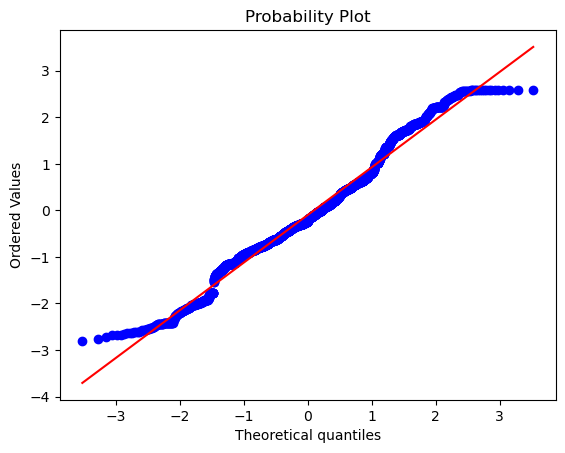

In [57]:
from scipy import stats
stats.probplot(res.ravel(), dist="norm", plot= plt)

In [16]:
y_hat_scl = np.zeros(6)
y_temp = y.copy()

for i in range(6):
    x_test_temp = y_temp[-(timesteps-1):].reshape(1, (timesteps-1))
    y_hat_scl[i] = model.predict(x_test_temp)[:,0]
    y_temp = np.append(y_temp, y_hat_scl[i])


1/1 [==============================] - 0s 31ms/step


In [65]:
y_hat_scl.shape, x_test_temp.shape, y_temp.shape

((6,), (1, 12), (63,))

In [17]:
#y_hat_scl = y_hat_scl - 4 #shiftback
y_hat = train_transformer.inverse_transform(y_hat_scl.reshape(-1,1)) #transform box cox inverse
#compare
error_svr = data_test.values / y_hat.ravel() - 1
error_svr

array([ 0.02005122, -0.0614536 , -0.02075319, -0.2594357 , -0.03808088,
       -0.22091277])

In [18]:
y_hat

array([[6362835.68359233],
       [6252814.67898688],
       [6372801.54499905],
       [6232829.68427154],
       [6385943.10609051],
       [6094086.07363188]])